In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import Model, layers

/home/piai/anaconda3/envs/pytorch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = tfds.load('mnist', split='train') # MNIST Data load 
train_data = dataset.map(lambda data: tf.cast(data['image'], tf.float32) / 255.).batch(1024) # data에서 이미지정보만 뽑아서 Normalizing

2022-07-29 14:28:49.124251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-29 14:28:50.108458: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6476 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:03:00.0, compute capability: 7.5
2022-07-29 14:28:50.109044: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6647 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:04:00.0, compute capability: 7.5


In [3]:
# 모델 정의
class Vanila_Encoder(Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(latent_dim * 2)
        ])
        
    def call(self, x):
        mu, logvar = tf.split(self.encoder(x), 2, axis=1) ## self.encoder(x)의 값을 1축 방향으로 반으로 나누어 쪼갠뒤 각각의 값을 mu, logvar로 만듭니다.
        
        return mu, logvar

In [4]:
# 모델 정의
class Vanila_Decoder(Model):
    def __init__(self, latent_dim):
        super().__init__()
        
        self.latent_dim = latent_dim
        self.decoder = tf.keras.Sequential([
            layers.Dense(256, activation='relu'), # (batch, 7*7*32) , input_shape=(latent_dim,)
            layers.Dense(512, activation='relu'), # (batch, 7*7*32) , input_shape=(latent_dim,)
            layers.Dense(784, activation='sigmoid'), # (batch, 7*7*32) , input_shape=(latent_dim,)
            layers.Reshape((28,28, 1))
        ])
        
    def call(self, z):
        return self.decoder(z)

In [5]:
# 모델의 하이퍼 파라미터 세팅
n_epochs = 50
latent_dim = 2
learning_rate = 1e-3
log_interval = 10

In [6]:
# 모델 객체 생성 위에서 만든 붕어빵 틀로 붕어빵 만드는 과정!
encoder = Vanila_Encoder(latent_dim)
decoder = Vanila_Decoder(latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [7]:
# 샘플링 하는 과정
def sample(mu, logvar):
    epsilon = tf.random.normal(mu.shape)
    sigma = tf.exp(0.5 * logvar) ## var==sigma^2 
    return epsilon * sigma + mu

In [8]:
# Input을 받아서 Gradient descent 한 번 하는 과정까지!
@tf.function # decorator 즉시 실행으로 바꿔줌
def train_step(inputs):
    with tf.GradientTape() as tape: # 이 부분은 그래디언트를 추적하겠다!
        mu, logvar = encoder(inputs) # (batch, latent_dim), (batch, latent_dim) q(z|x)
        z = sample(mu, logvar) # 인코더에서 뽑은 평균과 분산으로 샘플링 
        x_recon = decoder(z) # 샘플링된 것을 다시 Recon p(x|z)
        reconstruction_error = tf.reduce_sum(tf.losses.binary_crossentropy(inputs, x_recon)) # log p(x|z)
        kl = 0.5 * tf.reduce_sum(tf.exp(logvar) + tf.square(mu) - 1. - logvar) # KL(p(z)|q(z|x))
        loss = (kl + reconstruction_error) / inputs.shape[0] # 각 샘플당 로스로!
         
    vars_ = encoder.trainable_variables + decoder.trainable_variables # get trainable parameter
    grads_ = tape.gradient(loss, vars_) # get grads
    optimizer.apply_gradients(zip(grads_, vars_)) # applyling gradient descent

    return loss, reconstruction_error, kl

In [9]:
for epoch in range(1, n_epochs + 1):    
    total_loss, total_recon, total_kl = 0, 0, 0
    for x in train_data:
        loss, recon, kl = train_step(x)
        # loss 저장
        total_loss += loss * x.shape[0]
        # error 저장
        total_recon += recon
        # total KL 저장
        total_kl += kl
    
    if epoch % log_interval == 0:
        # epoch 동안 평균 로스
        print(
            f'{epoch:3d} iteration: ELBO {total_loss / len(dataset):.2f}, ' \
            f'Recon {total_recon / len(dataset):.2f}, ' \
            f'KL {total_kl / len(dataset):.2f}'
        )

 10 iteration: ELBO 157.20, Recon 151.73, KL 5.46
 20 iteration: ELBO 149.57, Recon 143.60, KL 5.98
 30 iteration: ELBO 145.82, Recon 139.55, KL 6.26
 40 iteration: ELBO 143.42, Recon 136.98, KL 6.44
 50 iteration: ELBO 141.53, Recon 135.00, KL 6.53


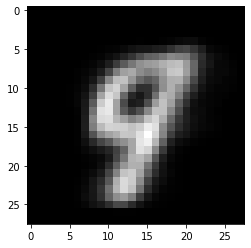

In [12]:
mu = tf.zeros((1, latent_dim))
logvar = tf.zeros((1, latent_dim))

z = sample(mu, logvar)
x = decoder(z)
plt.imshow(x[0, :, :, 0], cmap='gray')

In [15]:
!pip install -U tensorflow-probability==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 790.8/790.8 kB 7.3 MB/s eta 0:00:00a 0:00:01


In [16]:
import tensorflow_probability as tfp


# -2~2까지 z값에 대하여 뽑기!
def plot_latent_images(n, digit_size=28):
    digit_size = 28
    scale = 2.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder(z_sample).numpy()
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

AttributeError: module 'tensorflow' has no attribute 'contrib'

In [14]:
plot_latent_images(20)

NameError: name 'plot_latent_images' is not defined

In [ ]:
test_dataset = tfds.load('mnist', split='test') # MNIST Data load 
test_data = test_dataset.map(lambda data: (tf.cast(data['image'], tf.float32) / 255., data['label'])).batch(1024) # data에서 이미지정보만 뽑아서 Normalizing

In [ ]:
x_axis = []
y_axis = []
label_list = []
for image, label in test_data:
    mu, logvar = encoder(image)
    x_axis.append(mu[:,0] + tf.exp(0.5*logvar)[:,0])
    y_axis.append(mu[:,1] + tf.exp(0.5*logvar)[:,1])
    label_list.append(label.numpy())

In [ ]:
x_axis = np.concatenate(x_axis, axis=0)
y_axis = np.concatenate(y_axis, axis=0)
label_list = np.concatenate(label_list, axis=0)

In [ ]:
scatter_plot = plt.scatter(x_axis, y_axis, c=label_list, label=label_list)
plt.legend(handles = scatter_plot.legend_elements()[0], labels=[i for i in range(10)])

In [ ]:
image_sample = next(iter(test_dataset))['image']
image_sample = tf.expand_dims(image_sample, axis=0)

In [ ]:
mu, logvar = encoder(image_sample/255)
z = sample(mu, logvar)
print(mu)
x = decoder(z)

In [ ]:
plt.imshow(image_sample[0,:, :, 0], cmap='gray')

In [ ]:
plt.imshow(x[0, :, :, 0], cmap='gray')

## Conditional VAE

In [ ]:
class Condition_Encoder(Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.flatten = layers.Flatten()
        self.depth = 10
        self.encoder = tf.keras.Sequential([
            layers.Dense(512, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(latent_dim * 2)
        ])
        
    def call(self, x, label):
        x = self.flatten(x)
        label = tf.one_hot(label, self.depth)
        x = tf.keras.layers.concatenate([x, label])
        mu, logvar = tf.split(self.encoder(x), 2, axis=1) ## self.encoder(x)의 값을 1축 방향으로 반으로 나누어 쪼갠뒤 각각의 값을 mu, logvar로 만듭니다.
        
        return mu, logvar

In [ ]:
class Condition_Decoder(Model):
    def __init__(self, latent_dim):
        super().__init__()
        
        self.latent_dim = latent_dim
        self.depth = 10
        self.decoder = tf.keras.Sequential([
            layers.Dense(256, activation='relu'), # (batch, 7*7*32) , input_shape=(latent_dim,)
            layers.Dense(512, activation='relu'), # (batch, 7*7*32) , input_shape=(latent_dim,)
            layers.Dense(784, activation='sigmoid'), # (batch, 7*7*32) , input_shape=(latent_dim,)
            layers.Reshape((28,28, 1))
        ])
        
    def call(self, z, label):
        label = tf.one_hot(label, self.depth)
        z = tf.keras.layers.concatenate([z, label])
        return self.decoder(z)

In [ ]:
condition_encoder = Condition_Encoder(2)
condition_decoder = Condition_Decoder(2)

In [ ]:
dataset = tfds.load('mnist', split='train') # MNIST Data load 
train_data = dataset.map(lambda data: (tf.cast(data['image'], tf.float32) / 255., data['label'])).batch(1024)

In [ ]:
@tf.function # decorator 즉시 실행으로 바꿔줌
def train_step_condition(inputs, label):
    with tf.GradientTape() as tape: # 이 부분은 그래디언트를 추적하겠다!
        mu, logvar = condition_encoder(inputs, label) # (batch, latent_dim), (batch, latent_dim) q(z|x)
        z = sample(mu, logvar) # 인코더에서 뽑은 평균과 분산으로 샘플링 
        x_recon = condition_decoder(z, label) # 샘플링된 것을 다시 Recon p(x|z)
        reconstruction_error = tf.reduce_sum(tf.losses.binary_crossentropy(inputs, x_recon)) # log p(x|z)
        kl = 0.5 * tf.reduce_sum(tf.exp(logvar) + tf.square(mu) - 1. - logvar) # KL(p(z)|q(z|x))
        loss = (kl + reconstruction_error) / inputs.shape[0] # 각 샘플당 로스로!
         
    vars_ = condition_encoder.trainable_variables + condition_decoder.trainable_variables # get trainable parameter
    grads_ = tape.gradient(loss, vars_) # get grads
    optimizer.apply_gradients(zip(grads_, vars_)) # applyling gradient descent

    return loss, reconstruction_error, kl

In [ ]:
for epoch in range(1, n_epochs + 1):    
    total_loss, total_recon, total_kl = 0, 0, 0
    for x, y in train_data:
        loss, recon, kl = train_step_condition(x, y)
        # loss 저장
        total_loss += loss * x.shape[0]
        # error 저장
        total_recon += recon
        # total KL 저장
        total_kl += kl
    
    if epoch % log_interval == 0:
        # epoch 동안 평균 로스
        print(
            f'{epoch:3d} iteration: ELBO {total_loss / len(dataset):.2f}, ' \
            f'Recon {total_recon / len(dataset):.2f}, ' \
            f'KL {total_kl / len(dataset):.2f}'
        )

In [ ]:
mu = tf.zeros((1, latent_dim))
logvar = tf.zeros((1, latent_dim))
z = sample(mu, logvar)
label = tf.convert_to_tensor([3])
x = condition_decoder(z, label)
plt.imshow(x[0, :, :, 0], cmap='gray')